# 单个子结构搜索与展示

* 首先初始化一个分子，并设置一个要搜索的SMARTS/SMILES

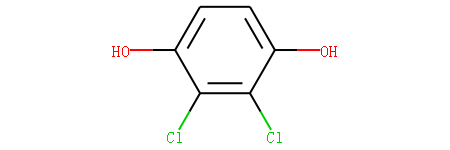

In [10]:
from rdkit import Chem
from rdkit.Chem.Draw import rdMolDraw2D
smi = 'Clc1c(Cl)c(O)ccc1O'
mol = Chem.MolFromSmiles(smi)
patt = Chem.MolFromSmarts('ClccO')
mol

## 1.判断是否包含子结构
* 通过SMARTS判断是否存在子结构：HasSubstructMatch(query, recursionPossible, useChirality, ...)<br />
query：要搜索的SMARTS子结构<br />
recursionPossible：允许递归查询，默认True<br />
useChirality：匹配立体化学信息，默认False<br />

In [2]:
mol.HasSubstructMatch(patt)

True

## 2.搜索并返回子结构
* 返回匹配子结构：GetSubstructMatch(query, useChirality, ...)<br />
参数类似上面的函数<br />
该函数只返回一个匹配的结构。返回值是一个整数元组<br />
整数元组的每一位，依次对应SMARTS中的每个原子，每一位上的整数，代表原始分子中匹配的原子索引

In [3]:
hit_at = mol.GetSubstructMatch(patt)
print(hit_at)

(0, 1, 8, 9)


* 查看该子结构：MolFragmentToSmiles<br />
这只不过是一句正确的废话，根据SMRATS查询，返回的肯定是对应的结构了

In [5]:
print(Chem.MolFragmentToSmiles(mol, atomsToUse=hit_at, rootedAtAtom=0))
print(Chem.MolFragmentToSmiles(mol, atomsToUse=hit_at, rootedAtAtom=9))

ClccO
OccCl


## 3.获取匹配的原子和索引
* 创建hit_bond接收匹配上的键
* 遍历patt中的键：patt.GetBonds()
* 获取键两端的原子索引：bond.GetBeginAtomIdx()
* 通过hit_at映射，得到原始分子中对应的键：GetBondBetweenAtoms(aid1, aid2)
* 获取键索引：Bond.GetIdx()

In [12]:
hit_bond = []
for bond in patt.GetBonds():
    aid1 = hit_at[bond.GetBeginAtomIdx()]
    aid2 = hit_at[bond.GetEndAtomIdx()]
    hit_bond.append(mol.GetBondBetweenAtoms(aid1, aid2).GetIdx())
hit_bond

[0, 9, 8]

## 4.绘制子结构
* 创建一个画板：MolDraw2DSVG，或MolDraw2DCairo
* 在画板中绘制：PrepareAndDrawMolecule(drawer, mol, highlightAtoms, highlightBonds, confId,...)<br />
drawer：画板<br />
mol：mol对象<br />
highlightAtoms/Bonds：高亮的原子/键<br />
confID：绘制的第几个构象
* 保存png图片：WriteDrawingText()

In [14]:
d = rdMolDraw2D.MolDraw2DCairo(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=list(hit_at), 
                                   highlightBonds=hit_bond)

d.FinishDrawing()
d.WriteDrawingText('data/sigle_highlighted.png')

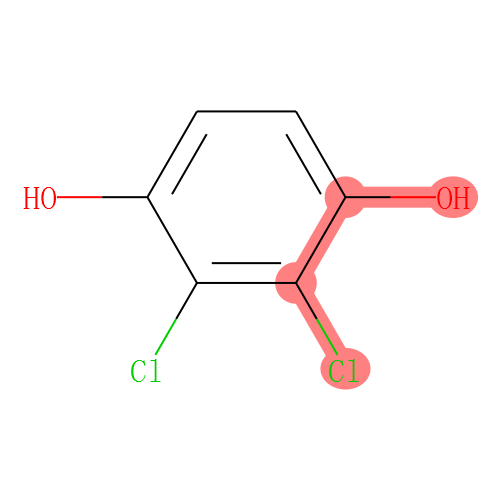

In [15]:
from IPython.display import Image
Image(filename = 'data/sigle_highlighted.png', width=150, height=150)

# 高亮展示多个匹配子结构

* 和上面流程一样，先初始化mol和patt

In [13]:
mol = Chem.MolFromSmiles('Clc1c(Cl)c(O)ccc1O')
patt = Chem.MolFromSmarts('ClccO')

## 1.搜索并返回所有子结构
* 返回所有所有子结构：GetSubstructMatches(query, uniquify, useChirality, maxMatches, ...)<br />
uniquify：检测是否唯一<br />
maxMatches：返回的最大匹配的子结构数量

In [17]:
hit_ats = mol.GetSubstructMatches(patt)
print(hit_ats)

((0, 1, 8, 9), (3, 2, 4, 5))


## 2.获取匹配的原子和索引
* 思路和上面基本一致，获取所有匹配的键

In [18]:
bond_lists = []
for i, hit_at in enumerate(hit_ats):
    hit_at = list(hit_at)
    bond_list = []
    for bond in patt.GetBonds():
        a1 = hit_at[bond.GetBeginAtomIdx()]
        a2 = hit_at[bond.GetEndAtomIdx()]
        bond_list.append(mol.GetBondBetweenAtoms(a1, a2).GetIdx())
    bond_lists.append(bond_list)
print(bond_lists)

[[0, 9, 8], [2, 3, 4]]


## 3.设置原子和键的颜色
* 使用不同颜色绘制不同的匹配结构<br />
创建颜色的列表colours，列表中的每个元组代表（红绿蓝）的色彩信息<br />
创建原子字典atom_cols，键为原子索引，值为色彩信息<br />
同上创建键的字典bond_cols<br />
并将原子和键汇总到atom_list和bond_list中

In [19]:
colours = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]
atom_cols = {}
bond_cols = {}
atom_list = []
bond_list = []
for i, (hit_atom, hit_bond) in enumerate(zip(hit_ats, bond_lists)):
    hit_atom = list(hit_atom)
    for at in hit_atom:
        atom_cols[at] = colours[i%3]
        atom_list.append(at)
    for bd in hit_bond:
        bond_cols[bd] = colours[i%3]
        bond_list.append(bd)
atom_cols

{0: (1, 0, 0),
 1: (1, 0, 0),
 8: (1, 0, 0),
 9: (1, 0, 0),
 3: (0, 1, 0),
 2: (0, 1, 0),
 4: (0, 1, 0),
 5: (0, 1, 0)}

In [20]:
bond_cols

{0: (1, 0, 0),
 9: (1, 0, 0),
 8: (1, 0, 0),
 2: (0, 1, 0),
 3: (0, 1, 0),
 4: (0, 1, 0)}

## 4.绘制多个子结构
* 创建画板：MolDraw2DSVG，或MolDraw2DCairo
* 在画板中绘制：PrepareAndDrawMolecule(drawer, mol, highlightAtoms, highlightBonds, highlightAtomColors, highlightBondColors, confId,...)

highlightAtoms/Bonds：高亮原子/键

highlightAtom/BondColors：显示的颜色
* 保存png图片：WriteDrawingText('test1.png')

In [21]:
d = rdMolDraw2D.MolDraw2DCairo(500, 500)
rdMolDraw2D.PrepareAndDrawMolecule(d, mol, highlightAtoms=atom_list,
                                   highlightAtomColors=atom_cols,
                                   highlightBonds=bond_list,
                                   highlightBondColors=bond_cols)
with open('data/multi_highlighted.png', 'wb') as f:
    f.write(d.GetDrawingText())

* 展示一下

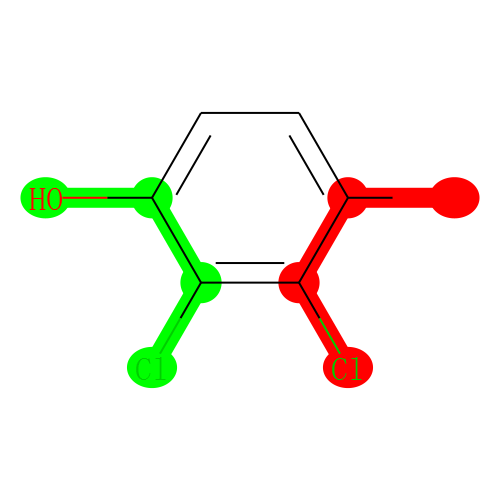

In [22]:
from IPython.display import Image
Image(filename = 'data/multi_highlighted.png', width=150, height=150)